In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import duckdb
from scipy import stats

sns.set_style("whitegrid")
from scikit_posthocs import posthoc_dunn

---
### Host range

In [2]:
df = pl.read_csv(
    "../crispr_search/plasmid_host_taxonomy_consolidated_all_possible_hosts_final_derep.tsv",
    separator="\t",
)

df.head()

Plasmid,host,method
str,str,str
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast"""
"""2088090015|GPI…","""d__Bacteria;p_…","""iphop-blast"""


In [3]:
df.unique("Plasmid").shape[0]

56764

In [4]:
df = df.with_columns(
    phylum=pl.col("host").str.split(";").list.get(1),
    cclass=pl.col("host").str.split(";").list.get(2),
    order=pl.col("host").str.split(";").list.get(3),
    family=pl.col("host").str.split(";").list.get(4),
    genus=pl.col("host").str.split(";").list.get(5),
    species=pl.col("host").str.split(";").list.get(6),
)

df.head()

Plasmid,host,method,phylum,cclass,order,family,genus,species
str,str,str,str,str,str,str,str,str
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…","""s__Methylocean…"
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…",null
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…",null
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…","""s__2-02-FULL-6…"
"""2088090015|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Actinomycet…","""c__Thermoleoph…","""o__Gaiellales""","""f__Gaiellaceae…","""g__GMQP-bins7""",null


In [5]:
con = duckdb.connect("../soil_plasmid.db")
ptus = con.sql("SELECT * FROM ptu_derep").df().set_index("pOTU")
con.close()

ptus_mapping = {}

for i in ptus.index:
    plasmids = ptus.loc[i]["Members"].split(",")
    for plasmid in plasmids:
        if "IMGPR" in plasmid:
            plasmid = plasmid.split("|")[0]
        ptus_mapping[plasmid] = i

In [ ]:
df_envs = pl.read_csv(
    "../env_corr/taxon_countries.tsv", separator="\t", dtypes={"taxon_oid": pl.Utf8}
)
df_envs.head()

taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,Plasmid Count,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
str,str,f64,f64,str,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,str,str,str,str,f64,str
"""3300049023""","""Grasslands""",38.53,-121.78,"""Meta""","""USA""","""Grasslands""",36,"""Luvisols""",152,252,4,267,395,332,69,171,562,335,"""POINT (-121.78…",761.0,"""Great Central …","""NA""","""NA12""","""Nearctic""",12.0,"""Mediterranean …"
"""3300012840""","""Grasslands""",43.07,-89.4,"""Meta""","""USA""","""Grasslands""",21,"""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-89.4 4…",187.0,"""Prairie-Forest…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""3300039503""","""Unclassified""",63.88,-149.23,"""Meta""","""USA""","""Unclassified""",3,"""Cambisols""",60,541,112,137,1084,670,49,367,496,2409,"""POINT (-149.23…",734.0,"""Alaska Range""","""NA""","""NA6""","""Nearctic""",6.0,"""Boreal Forests…"
"""3300042005""","""Rhizosphere""",41.2,-97.94,"""Meta""","""USA""","""Rhizosphere""",6,"""Kastanozems""",135,182,3,163,299,377,63,594,242,301,"""POINT (-97.94 …",747.0,"""Central Mixed-…","""NA""","""NA8""","""Nearctic""",8.0,"""Temperate Gras…"
"""3300049265""","""Agricultural l…",38.55,-121.87,"""Meta""","""USA""","""Agricultural l…",1,"""Vertisols""",158,235,8,297,253,330,69,195,508,274,"""POINT (-121.87…",761.0,"""Great Central …","""NA""","""NA12""","""Nearctic""",12.0,"""Mediterranean …"


In [7]:
df = df.with_columns(ptu=pl.col("Plasmid").map_elements(lambda x: ptus_mapping.get(x)))

In [8]:
df.unique("Plasmid").shape[0]

56764

In [9]:
df.filter((pl.col("species").is_not_null()) & (pl.col("species") != "s__")).unique(
    "Plasmid"
).shape[0]

50724

In [10]:
df = df.with_columns(
    ptu=pl.col("Plasmid").map_elements(lambda x: ptus_mapping.get(x)),
    taxon_oid=pl.col("Plasmid").map_elements(
        lambda x: x.split("|")[0] if "IMGPR" not in x else x.split("_")[2]
    ),
).join(df_envs.drop(["Plasmid Count", "PTU Count"]), on="taxon_oid")
# df = df.drop_nulls(subset=["ptu"])
df.head()

Plasmid,host,method,phylum,cclass,order,family,genus,species,ptu,taxon_oid,Ecosystem Subtype,Latitude,Longitude,Origin,Isolation Country,Ecosystem Subtype Custom,soil_class,bdod (cg/cm³),cec (mmol(c)/kg),cfvo (cm³/dm³),clay (g/kg),nitrogen (cg/kg),ocd (dg/dm³),phh2o (pH*10),sand (g/kg),silt (g/kg),soc (dg/kg),geometry,index_right,ECO_NAME,WWF_REALM,RealmMHT,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM
str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,str,str,str,str,f64,str
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…","""s__Methylocean…","""pOTU-04071""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""USA""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Pseudomonad…","""c__Alphaproteo…","""o__Rhizobiales…","""f__Methylolige…","""g__Methylocean…",null,"""pOTU-04071""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""USA""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…",null,"""pOTU-57264""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""USA""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""2088090014|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Acidobacter…","""c__Vicinamibac…","""o__Vicinamibac…","""f__UBA2999""","""g__2-02-FULL-6…","""s__2-02-FULL-6…","""pOTU-57264""","""2088090014""","""Grasslands""",39.0,-77.1,"""Meta""","""USA""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"
"""2088090015|GPI…","""d__Bacteria;p_…","""iphop-blast""","""p__Actinomycet…","""c__Thermoleoph…","""o__Gaiellales""","""f__Gaiellaceae…","""g__GMQP-bins7""",null,"""pOTU-06613""","""2088090015""","""Grasslands""",39.0,-77.1,"""Meta""","""USA""","""Grasslands""","""Luvisols""",null,null,null,null,null,null,null,null,null,null,"""POINT (-77.1 3…",710.0,"""Lower New Engl…","""NA""","""NA4""","""Nearctic""",4.0,"""Temperate Broa…"


In [11]:
df.unique("Plasmid").shape[0]

56717

In [12]:
# with open("../plasmid_list_compare.txt", "w") as f:
#     for plasmid in df.unique("Plasmid").get_column("Plasmid").to_list():
#         f.write(f"{plasmid}\n")


In [13]:
ptus["n_ecosystems"] = ptus["Ecosystem Subtype Custom"].apply(
    lambda x: len(set(x.split((";"))))
)
ptus.head()

,Representative,Members,Length,oids,Ecosystem Subtype Custom,Ecosystem Subtype,WWF_MHTNAM,Origin,Full_origin,n_ecosystems
pOTU,,,,,,,,,,
pOTU-00000,3300056587|Ga0562382_00532,"3300056587|Ga0562382_00532,3300041809|Ga045567...",187,"3300056587,3300041809,3300056587,3300055278,33...",Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Peat;Grasslands;Peat;Temperate forest;Peat;Pea...,Tundra;Temperate Conifer Forests;Tundra;Temper...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,7
pOTU-00001,3300056791|Ga0562384_00281,"3300056791|Ga0562384_00281,3300054973|Ga049542...",158,"3300056791,3300054973,3300047661,3300051166,33...",Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;Peat;P...,Tundra;Tundra;Tundra;Tundra;Tundra;Tundra;Tund...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,3
pOTU-00002,3300046709|Ga0495471_0000157,"3300046709|Ga0495471_0000157,3300046788|Ga0495...",105,"3300046709,3300046788,3300046461,3300046811,33...",Agricultural land;Agricultural land;Rhizospher...,Agricultural land;Agricultural land;Rhizospher...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,5
pOTU-00003,3300046559|Ga0495667_0000358,"3300046559|Ga0495667_0000358,3300036401|Ga0373...",98,"3300046559,3300036401,3300046543,3300046724,33...",Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Rhizosphere;Rhizosphere;Rhizosphere;Agricultur...,Temperate Conifer Forests;Temperate Conifer Fo...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,7
pOTU-00004,3300056834|Ga0562381_00901,"3300056834|Ga0562381_00901,3300056587|Ga056238...",85,"3300056834,3300056587,3300048796,3300048785,33...",Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Peat;Peat;Peat;Peat;Peat;Temperate forest;Gras...,Tundra;Tundra;Tundra;Tundra;Tundra;Temperate C...,Meta,Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;Meta;M...,6


In [14]:
ptus[
    (ptus["Ecosystem Subtype Custom"] != "Unclassified")
    & (ptus["Length"] > 1)
    & (ptus["n_ecosystems"] == 1)
].shape[0]

10438

In [15]:
ptus[
    (ptus["Ecosystem Subtype Custom"] != "Unclassified")
    & (ptus["Length"] > 1)
    & (ptus["n_ecosystems"] > 1)
].shape[0]

4769

In [16]:
df_spps_ecos = (
    df.drop_nulls(subset="species")
    .unique(subset=["Plasmid", "species"])
    .filter(pl.col("Ecosystem Subtype Custom") != "Unclassified")
    .group_by("species")
    .agg(
        pl.col("Ecosystem Subtype Custom").unique(),
        pl.col("Ecosystem Subtype Custom").n_unique().alias("n_ecosystems"),
        pl.col("ptu").unique(),
        pl.col("ptu").n_unique().alias("n_ptus"),
    )
    .sort("n_ecosystems", descending=True)
)
df_spps_ecos.head()

species,Ecosystem Subtype Custom,n_ecosystems,ptu,n_ptus
str,list[str],u32,list[str],u32
"""s__Klebsiella …","[""Agricultural land"", ""Tropical forest"", … ""Temperate forest""]",7,"[""pOTU-26006"", ""pOTU-18101"", … ""pOTU-21772""]",184
"""s__Sulfotelmat…","[""Tropical forest"", ""Rhizosphere"", … ""Agricultural land""]",7,"[""pOTU-49655"", ""pOTU-50627"", … ""pOTU-36902""]",89
"""s__Bradyrhizob…","[""Tropical forest"", ""Temperate forest"", … ""Other""]",7,"[""pOTU-10069"", ""pOTU-00007"", … ""pOTU-03911""]",90
"""s__Bradyrhizob…","[""Peat"", ""Agricultural land"", … ""Rhizosphere""]",7,"[""pOTU-14697"", ""pOTU-03263"", … ""pOTU-03312""]",36
"""s__Bradyrhizob…","[""Tropical forest"", ""Temperate forest"", … ""Other""]",7,"[""pOTU-22475"", ""pOTU-00374"", … ""pOTU-06935""]",63


In [17]:
df_spps_ecos.filter((pl.col("n_ecosystems") > 1) & (pl.col("n_ptus") > 1))

species,Ecosystem Subtype Custom,n_ecosystems,ptu,n_ptus
str,list[str],u32,list[str],u32
"""s__Klebsiella …","[""Agricultural land"", ""Tropical forest"", … ""Temperate forest""]",7,"[""pOTU-26006"", ""pOTU-18101"", … ""pOTU-21772""]",184
"""s__Sulfotelmat…","[""Tropical forest"", ""Rhizosphere"", … ""Agricultural land""]",7,"[""pOTU-49655"", ""pOTU-50627"", … ""pOTU-36902""]",89
"""s__Bradyrhizob…","[""Tropical forest"", ""Temperate forest"", … ""Other""]",7,"[""pOTU-10069"", ""pOTU-00007"", … ""pOTU-03911""]",90
"""s__Bradyrhizob…","[""Peat"", ""Agricultural land"", … ""Rhizosphere""]",7,"[""pOTU-14697"", ""pOTU-03263"", … ""pOTU-03312""]",36
"""s__Bradyrhizob…","[""Tropical forest"", ""Temperate forest"", … ""Other""]",7,"[""pOTU-22475"", ""pOTU-00374"", … ""pOTU-06935""]",63
"""s__Chersky-822…","[""Agricultural land"", ""Temperate forest"", … ""Peat""]",7,"[""pOTU-29457"", ""pOTU-00077"", … ""pOTU-09825""]",39
"""s__Bradyrhizob…","[""Tropical forest"", ""Peat"", … ""Grasslands""]",7,"[""pOTU-03921"", ""pOTU-49067"", … ""pOTU-28062""]",89
"""s__Bradyrhizob…","[""Peat"", ""Other"", … ""Agricultural land""]",7,"[""pOTU-50239"", ""pOTU-02473"", … ""pOTU-54811""]",170
"""s__Bradyrhizob…","[""Temperate forest"", ""Other"", … ""Agricultural land""]",7,"[""pOTU-01092"", ""pOTU-01633"", … ""pOTU-30404""]",78


In [18]:
df_spps_ecos.filter((pl.col("n_ecosystems") == 1) & (pl.col("n_ptus") > 1)).sort(
    "n_ptus", descending=True
)

species,Ecosystem Subtype Custom,n_ecosystems,ptu,n_ptus
str,list[str],u32,list[str],u32
"""s__Pseudomonas…","[""Rhizosphere""]",1,"[""pOTU-25204"", ""pOTU-00986"", … ""pOTU-13525""]",56
"""s__Fen-455 sp0…","[""Peat""]",1,"[""pOTU-51722"", ""pOTU-00534"", … ""pOTU-54260""]",50
"""s__Novosphingo…","[""Rhizosphere""]",1,"[""pOTU-32315"", ""pOTU-41588"", … ""pOTU-14349""]",44
"""s__Novosphingo…","[""Rhizosphere""]",1,"[""pOTU-05644"", ""pOTU-00520"", … ""pOTU-02936""]",37
"""s__Pseudomonas…","[""Rhizosphere""]",1,"[""pOTU-09786"", ""pOTU-00442"", … ""pOTU-46253""]",37
"""s__Mesorhizobi…","[""Rhizosphere""]",1,"[""pOTU-00674"", ""pOTU-51993"", … ""pOTU-02606""]",30
"""s__Sphingobium…","[""Rhizosphere""]",1,"[""pOTU-10517"", ""pOTU-13218"", … ""pOTU-44832""]",27
"""s__Palsa-513 s…","[""Peat""]",1,"[""pOTU-00862"", ""pOTU-07338"", … ""pOTU-10749""]",24
"""s__LD21 sp0031…","[""Peat""]",1,"[""pOTU-11762"", ""pOTU-51132"", … ""pOTU-02565""]",24


In [19]:
df_spps_ecos.filter((pl.col("n_ecosystems") > 1) & (pl.col("n_ptus") == 1)).sort(
    "n_ptus", descending=True
)

species,Ecosystem Subtype Custom,n_ecosystems,ptu,n_ptus
str,list[str],u32,list[str],u32
"""s__JADLFM01 sp…","[""Rhizosphere"", ""Tropical forest"", ""Grasslands""]",3,"[""pOTU-00135""]",1
"""s__Kosakonia s…","[""Temperate forest"", ""Other"", ""Tropical forest""]",3,"[""pOTU-00500""]",1
"""s__Intrasporan…","[""Grasslands"", ""Other""]",2,"[""pOTU-06172""]",1
"""s__Nitrosopola…","[""Agricultural land"", ""Rhizosphere""]",2,"[""pOTU-00177""]",1
"""s__Aeromicrobi…","[""Other"", ""Rhizosphere""]",2,"[""pOTU-00565""]",1
"""s__Nonomuraea …","[""Rhizosphere"", ""Agricultural land""]",2,"[""pOTU-00282""]",1
"""s__Aeromicrobi…","[""Temperate forest"", ""Grasslands""]",2,"[""pOTU-09021""]",1
"""s__Parvibaculu…","[""Temperate forest"", ""Peat""]",2,"[""pOTU-01181""]",1
"""s__Arthrobacte…","[""Agricultural land"", ""Rhizosphere""]",2,"[""pOTU-00016""]",1


Where are the environments of these hosts? Get it from dongying's data


In [20]:
df_dongying = pl.read_csv(
    "../crispr_search/COG0013.species.genome_and_metaG.map.gz", separator="\t"
)

df_dongying = df_dongying.with_columns(
    pl.col("Metagenomes_present").str.split(",")
).explode("Metagenomes_present")
df_dongying.head()


Genome,Metagenomes_present
str,str
"""GCA_002194565""","""3300005753"""
"""GCA_002194565""","""3300013794"""
"""GCA_002194565""","""3300014848"""
"""2811995048""","""3300005753"""
"""2811995048""","""3300013794"""


In [21]:
df_host_ids = pl.read_csv(
    "../crispr_search/plasmid_host_with_genome_map_fix_GCF.tsv", separator="\t"
)
df_host_ids = df_host_ids.with_columns(
    pl.when(~pl.col("Host genome").str.contains("GC"))
    .then(pl.col("Host genome").str.split("_").list.get(0))
    .otherwise(pl.col("Host genome"))
    .alias("fixed_genome")
)
df_host_ids.head()


Plasmid,Host genome,Host taxonomy,fixed_genome
str,str,str,str
"""2088090014|GPI…","""GCA_003135455""","""d__Bacteria;p_…","""GCA_003135455"""
"""2088090014|GPI…","""GCA_001767435""","""d__Bacteria;p_…","""GCA_001767435"""
"""2088090014|GPI…","""GCA_003225315""","""d__Bacteria;p_…","""GCA_003225315"""
"""2088090015|GPI…","""GCA_004366385""","""d__Bacteria;p_…","""GCA_004366385"""
"""2088090015|GPI…","""3300022899_3""","""d__Bacteria;p_…","""3300022899"""


In [22]:
df_dongying_filtered_hosts = (
    df_dongying.join(df_host_ids, left_on="Genome", right_on="fixed_genome")
    .select("Host genome", "Metagenomes_present", "Host taxonomy")
    .unique()
)
df_dongying_filtered_hosts.write_csv(
    "../crispr_search/host_environments.tsv", separator="\t"
)
df_dongying_filtered_hosts.head()

Host genome,Metagenomes_present,Host taxonomy
str,str,str
"""GCA_002685315""","""3300032073""","""d__Archaea;p__…"
"""GCA_001512375""","""3300038956""","""d__Archaea;p__…"
"""GCA_003162175""","""3300026474""","""d__Archaea;p__…"
"""GCA_003162175""","""3300036494""","""d__Archaea;p__…"
"""GCA_003162175""","""3300037164""","""d__Archaea;p__…"


In [23]:
df_spps_ecos.select(pl.col("species"), pl.col("ptu"))

species,ptu
str,list[str]
"""s__Klebsiella …","[""pOTU-26006"", ""pOTU-18101"", … ""pOTU-21772""]"
"""s__Sulfotelmat…","[""pOTU-49655"", ""pOTU-50627"", … ""pOTU-36902""]"
"""s__Bradyrhizob…","[""pOTU-10069"", ""pOTU-00007"", … ""pOTU-03911""]"
"""s__Bradyrhizob…","[""pOTU-14697"", ""pOTU-03263"", … ""pOTU-03312""]"
"""s__Bradyrhizob…","[""pOTU-22475"", ""pOTU-00374"", … ""pOTU-06935""]"
"""s__Chersky-822…","[""pOTU-29457"", ""pOTU-00077"", … ""pOTU-09825""]"
"""s__Bradyrhizob…","[""pOTU-03921"", ""pOTU-49067"", … ""pOTU-28062""]"
"""s__Bradyrhizob…","[""pOTU-50239"", ""pOTU-02473"", … ""pOTU-54811""]"
"""s__Bradyrhizob…","[""pOTU-01092"", ""pOTU-01633"", … ""pOTU-30404""]"


In [24]:
df_dongying_filtered_hosts.unique("Host genome").shape[0]

9782

In [25]:
# Soil Metagenomes + Isolates from IMG
df_envs.filter(~pl.col("taxon_oid").str.contains("PLSDB|Refsoil|MGY")).unique(
    "taxon_oid"
).shape[0]

5490

In [26]:
# Soil Metagenomes without isolates from IMG
df_envs.filter(
    (~pl.col("taxon_oid").str.contains("PLSDB|Refsoil|MGY"))
    & (pl.col("Origin") == "Meta")
).unique("taxon_oid").shape[0]

3198

In [27]:
# How many taxids from dongying are in my data?
df_dongying_filtered_hosts.filter(
    pl.col("Metagenomes_present").is_in(df_envs["taxon_oid"])
).unique("Host genome").shape[0]


3894

In [28]:
consolidated_hosts = (
    df_dongying_filtered_hosts.with_columns(
        species=pl.col("Host taxonomy").str.split(";").list.get(6)
    )
    .join(df_envs, left_on="Metagenomes_present", right_on="taxon_oid")
    .select(
        "Host genome",
        "Metagenomes_present",
        "Host taxonomy",
        "species",
        "Ecosystem Subtype Custom",
    )
    .filter(pl.col("Ecosystem Subtype Custom") != "Unclassified")
    .group_by("species")
    .agg(
        pl.col("Ecosystem Subtype Custom").unique().alias("ecosystems_host"),
        pl.col("Ecosystem Subtype Custom").n_unique().alias("n_ecosystems_host"),
    )
).join(df_spps_ecos.select(pl.col("species"), pl.col("ptu")), on="species")


consolidated_hosts.head()

species,ecosystems_host,n_ecosystems_host,ptu
str,list[str],u32,list[str]
"""s__Klebsiella …","[""Other"", ""Grasslands"", … ""Rhizosphere""]",4,"[""pOTU-26006"", ""pOTU-18101"", … ""pOTU-21772""]"
"""s__Sulfotelmat…","[""Temperate forest""]",1,"[""pOTU-49655"", ""pOTU-50627"", … ""pOTU-36902""]"
"""s__Bradyrhizob…","[""Temperate forest"", ""Rhizosphere"", … ""Grasslands""]",4,"[""pOTU-10069"", ""pOTU-00007"", … ""pOTU-03911""]"
"""s__Bradyrhizob…","[""Agricultural land""]",1,"[""pOTU-14697"", ""pOTU-03263"", … ""pOTU-03312""]"
"""s__Bradyrhizob…","[""Other"", ""Temperate forest""]",2,"[""pOTU-22475"", ""pOTU-00374"", … ""pOTU-06935""]"


A ptu may be in more than one environment and have more than one host. We need to check how many environments the ptu has, and then how many environments the host has.
Let's look at ptu environments and compare with host environments

In [30]:
ptu_data = (
    df.filter(pl.col("Ecosystem Subtype Custom") != "Unclassified")
    .group_by("ptu")
    .agg(
        pl.col("Ecosystem Subtype Custom").unique().alias("ecosystems_ptu"),
        pl.col("Ecosystem Subtype Custom").n_unique().alias("n_ecosystems_ptu"),
    )
)
host_data = consolidated_hosts.explode("ptu").select(
    "species", "ecosystems_host", "n_ecosystems_host", "ptu"
)
ptu_data.head()


ptu,ecosystems_ptu,n_ecosystems_ptu
str,list[str],u32
"""pOTU-19352""","[""Agricultural land""]",1
"""pOTU-10444""","[""Temperate forest"", ""Grasslands""]",2
"""pOTU-25177""","[""Rhizosphere""]",1
"""pOTU-27769""","[""Temperate forest""]",1
"""pOTU-28828""","[""Temperate forest""]",1


In [31]:
consolidated_hosts = (
    host_data.with_columns(pl.col("ecosystems_host").list.join(","))
    .group_by("ptu")
    .agg(
        pl.col("ecosystems_host"), pl.col("species").n_unique().alias("n_species_host")
    )
    .with_columns(pl.col("ecosystems_host").list.join(",").str.split(",").list.unique())
    .with_columns(n_ecosystems_host=pl.col("ecosystems_host").list.len())
    .join(ptu_data, on="ptu")
    .with_columns(
        delta_env=pl.col("n_ecosystems_host").cast(pl.Int32)
        - pl.col("n_ecosystems_ptu").cast(pl.Int32)
    )
)
consolidated_hosts.head()

ptu,ecosystems_host,n_species_host,n_ecosystems_host,ecosystems_ptu,n_ecosystems_ptu,delta_env
str,list[str],u32,u32,list[str],u32,i32
"""pOTU-10444""","[""Temperate forest"", ""Agricultural land"", ""Grasslands""]",6,3,"[""Temperate forest"", ""Grasslands""]",2,1
"""pOTU-25177""","[""Rhizosphere"", ""Agricultural land"", ""Grasslands""]",2,3,"[""Rhizosphere""]",1,2
"""pOTU-27769""","[""Temperate forest"", ""Other"", … ""Rhizosphere""]",14,5,"[""Temperate forest""]",1,4
"""pOTU-28828""","[""Grasslands"", ""Agricultural land"", ""Rhizosphere""]",6,3,"[""Temperate forest""]",1,2
"""pOTU-05889""","[""Other""]",2,1,"[""Peat""]",1,0


In [32]:
consolidated_hosts.filter(pl.col("delta_env") < 0)

ptu,ecosystems_host,n_species_host,n_ecosystems_host,ecosystems_ptu,n_ecosystems_ptu,delta_env
str,list[str],u32,u32,list[str],u32,i32
"""pOTU-00014""","[""Agricultural land"", ""Other"", … ""Grasslands""]",5,5,"[""Other"", ""Temperate forest"", … ""Tropical forest""]",6,-1
"""pOTU-12467""","[""Peat""]",4,1,"[""Temperate forest"", ""Grasslands""]",2,-1
"""pOTU-00035""","[""Other"", ""Peat"", ""Temperate forest""]",3,3,"[""Grasslands"", ""Temperate forest"", … ""Agricultural land""]",5,-2
"""pOTU-00357""","[""Temperate forest"", ""Rhizosphere""]",2,2,"[""Rhizosphere"", ""Other"", ""Agricultural land""]",3,-1
"""pOTU-09017""","[""Temperate forest""]",1,1,"[""Agricultural land"", ""Other""]",2,-1
"""pOTU-00013""","[""Agricultural land""]",1,1,"[""Other"", ""Temperate forest""]",2,-1
"""pOTU-08977""","[""Agricultural land""]",1,1,"[""Other"", ""Agricultural land""]",2,-1
"""pOTU-14814""","[""Rhizosphere""]",1,1,"[""Temperate forest"", ""Rhizosphere""]",2,-1
"""pOTU-00173""","[""Peat""]",8,1,"[""Grasslands"", ""Peat""]",2,-1


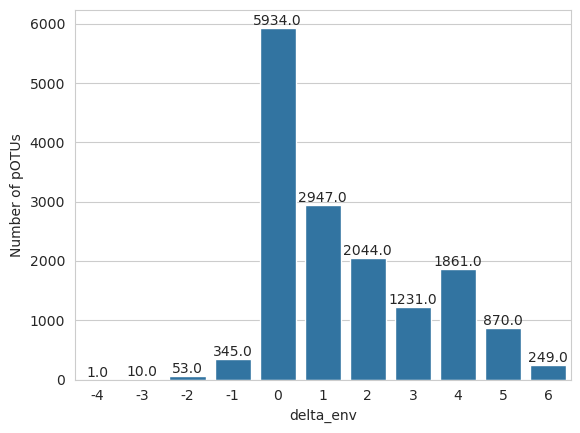

In [33]:
ax = sns.countplot(data=consolidated_hosts.to_pandas(), x="delta_env")
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

ax.set_ylabel("Number of pOTUs")
plt.savefig("../figures/delta_env_ptu_host.pdf", bbox_inches="tight")

In [34]:
host_data.filter(pl.col("ptu") == "pOTU-06934")

species,ecosystems_host,n_ecosystems_host,ptu
str,list[str],u32,str
"""s__Sphingomicr…","[""Other""]",1,"""pOTU-06934"""
"""s__Sphingomicr…","[""Other"", ""Agricultural land"", … ""Tropical forest""]",5,"""pOTU-06934"""
"""s__Sphingomicr…","[""Agricultural land""]",1,"""pOTU-06934"""
